<script>
    function findAncestor (el, name) {
        while ((el = el.parentElement) && el.nodeName.toLowerCase() !== name);
        return el;
    }
    function colorAll(el, textColor) {
        el.style.color = textColor;
        Array.from(el.children).forEach((e) => {colorAll(e, textColor);});
    }
    function setBackgroundImage(src, textColor) {
        var section = findAncestor(document.currentScript, 'section');
        if (section) {
            section.setAttribute('data-background-image', src);
			if (textColor) colorAll(section, textColor);
        }
    }
</script>

<style>
h1 {
  border: 1.5px solid #333;
  padding: 8px 12px;
  background-image: linear-gradient(#2774AE,#ebf8e1, #FFD100);
  position: static;
}
</style>

<h1 style='color:white'> Statistics 21 <br/> Python & Other Technologies for Data Science </h1>

<h3 style='color:white'>Vivian Lew, PhD - Monday, Week 8</h3>

<script>
    setBackgroundImage('Window1.jpg');
</script>

# Some Stats 
## Week 8 Monday

In [1]:
import numpy as np
import pandas as pd
from statsmodels import stats
import scipy as sp
import scipy.stats.distributions as dist
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics 

import seaborn as sns
from scikit_posthocs import posthoc_dunn

#For proper display of all columns
pd.options.display.max_columns = None

from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [2]:
bank_data = pd.read_csv('bank.csv', delimiter=';')
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


## Two Sample t test

Comparing two groups (housing yes/no) on their age difference. 

In [3]:
## define samples
group1 = bank_data[bank_data['housing']=='yes']
group2 = bank_data[bank_data['housing']=='no']

print(group1['age'].mean())
print(group2['age'].mean())

39.3747557639703
43.51172273190622


Those without a housing loan appear to be older, but is this a reasonable conclusion

In [4]:
# traditionally perform independent two sample t-test
stats.weightstats.ttest_ind(group1['age'], group2['age'])

(-13.285924321774523, 1.5281367117218135e-39, 4519.0)

In [5]:
stats.weightstats.ttest_ind(group1['age'], group2['age'],usevar='unequal')

(-12.771345935345085, 1.559912720111746e-36, 3464.966631382813)

## Resampling methods

Let's pretend our data is a population and we will sample from it instead.

And let's sample 5,000 times

In [6]:
n_iterations = 5000
sample_size = 100
t_stats = np.zeros(n_iterations)
p_values = np.zeros(n_iterations)
df = np.zeros(n_iterations)

for i in range(n_iterations):
    sample1 = np.random.choice(group1['age'], sample_size, replace=True )
    sample2 = np.random.choice(group2['age'], sample_size, replace=True)
    
    t_stat, p_value, df = stats.weightstats.ttest_ind(
        sample1, sample2, usevar='unequal'
    )
    
    t_stats[i] = t_stat
    p_values[i] = p_value

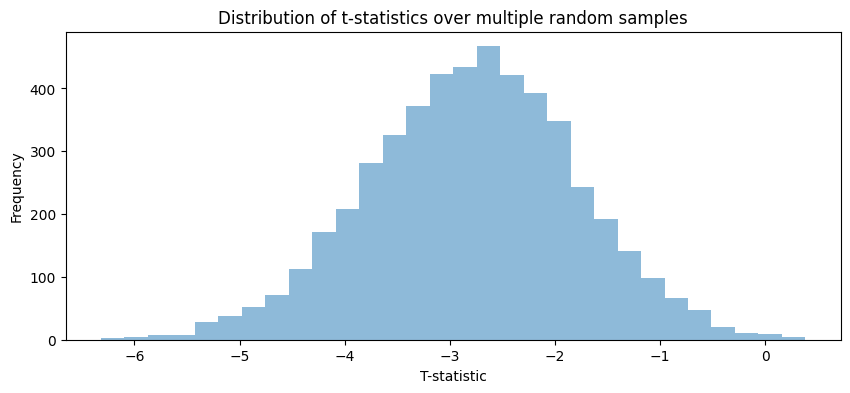

In [7]:
plt.figure(figsize=(10,4))
plt.hist(t_stats, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-statistics over multiple random samples')
plt.show()

In [8]:
t_stats[t_stats <= -2].size/n_iterations

0.7882

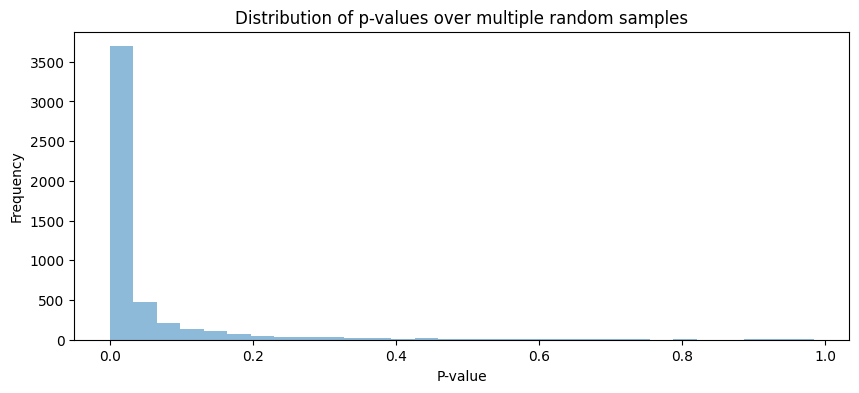

In [9]:
plt.figure(figsize=(10,4))
plt.hist(p_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples')
plt.show()

In [10]:
p_values[p_values <= 0.05].size/n_iterations

0.7978

## KW for more than 2 groups, non-parametric (otherwise ANOVA)

Kruskal Wallis, a non-parameteric (no assumptions about the functional form so it is robust but conservative) examining differences in > 2 groups. It is found in scipy.

Always need to run a post-hoc afterwards to interpret results.  Unfortunately it requires yet another library (scikit-posthocs)

In [11]:
## define samples

bank_data2 = bank_data[bank_data['poutcome'].isin(['failure','success'])].copy()
bank_data2['poutcome'] = bank_data2['poutcome'].replace({'failure': 0, 'success': 1})

bank_data_kw3 = bank_data2[bank_data2['job'].isin(
    ['management','blue-collar','technician'])].copy()

sp.stats.kruskal(bank_data_kw3['poutcome'][bank_data_kw3['job']=='management'],
              bank_data_kw3['poutcome'][bank_data_kw3['job']=='blue-collar'],
              bank_data_kw3['poutcome'][bank_data_kw3['job']=='technician'])

KruskalResult(statistic=6.71348505516922, pvalue=0.03484859258297617)

## Post-Hoc test

We had a `from scikit_posthocs import posthoc_dunn` above

Simple options: needs the dataframe, then val_col is the name of the value being compared, group_col is the grouping variable and p_adjust has different p-value adjustment options.

Bonferroni is easy to compute but conservative and more likely to give false negative

Hommel is computationally intensive but less likely to give false negative


In [12]:
dunn_df_bon = posthoc_dunn(
    bank_data_kw3, val_col='poutcome', group_col='job', p_adjust='bonferroni'
)
dunn_df_bon

,blue-collar,management,technician
blue-collar,1.000000,1.00000,0.031877
management,1.000000,1.00000,0.255880
technician,0.031877,0.25588,1.000000


In [13]:
dunn_df_hommel = posthoc_dunn(
    bank_data_kw3, val_col='poutcome', group_col='job', p_adjust='hommel'
)
dunn_df_hommel

,blue-collar,management,technician
blue-collar,1.000000,0.341952,0.031877
management,0.341952,1.000000,0.170587
technician,0.031877,0.170587,1.000000


## Resampling Kruskal Wallis results

In [14]:
n_iterations = 1000
sample_size = 100
K_results = np.zeros(n_iterations)
Kp_values = np.zeros(n_iterations)

for i in range(n_iterations):
    sample1 = np.random.choice(
        bank_data_kw3['poutcome'][bank_data_kw3['job']=='management'], sample_size)
    sample2 = np.random.choice(
        bank_data_kw3['poutcome'][bank_data_kw3['job']=='blue-collar'], sample_size)
    sample3 = np.random.choice(
        bank_data_kw3['poutcome'][bank_data_kw3['job']=='technician'], sample_size)
    
    k_stat, p_value = sp.stats.kruskal(
        sample1, sample2, sample3,
    )
    
    K_results[i] = k_stat
    Kp_values[i] = p_value

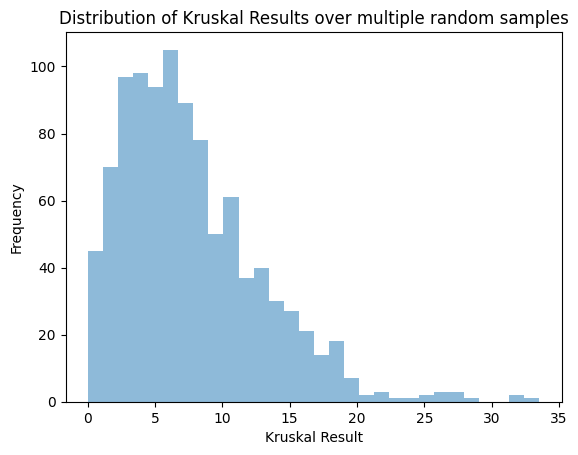

In [15]:
plt.hist(K_results, bins=30, alpha=0.5)
plt.xlabel('Kruskal Result')
plt.ylabel('Frequency')
plt.title('Distribution of Kruskal Results over multiple random samples')
plt.show()

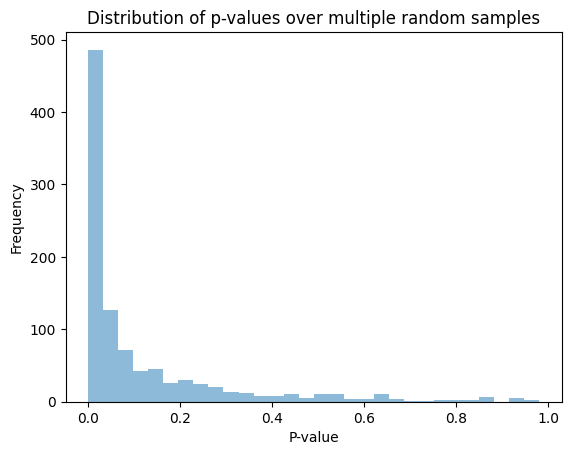

In [16]:
plt.hist(Kp_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples')
plt.show()

In [17]:
K_results[K_results >= 6].size/n_iterations

0.562

In [18]:
Kp_values[Kp_values <= 0.05].size/n_iterations

0.564

## Basic Regression

We have two files with a single set of values (heights and weights)

Open and convert to a data frame

In [19]:
with open('heights.txt', 'r') as file:
    x = []
    for i in file:
        x.append(float(i.strip()))
with open('weights.txt', 'r') as file:
    y = []
    for i in file:
        y.append(float(i.strip()))

In [20]:
df = pd.DataFrame({
    'intercept' : 1,
    'height': x,
    'weight': y
})
df

,intercept,height,weight
0,1,0.7,6.9
1,1,1.0,13.0
2,1,2.0,100.0
3,1,0.6,8.5
4,1,1.1,19.0
...,...,...,...
776,1,9.2,999.9
777,1,0.3,0.1
778,1,5.5,888.0
779,1,2.4,230.0


### Working with Numpy

You can put your linear algebra skills to work and program a regression. 

In [21]:
# create X and y
X = df[['intercept', 'height']].values
y = df['weight'].values

Find $X^T$ (X transpose)

In [22]:
X.T

array([[1. , 1. , 1. , ..., 1. , 1. , 1. ],
       [0.7, 1. , 2. , ..., 5.5, 2.4, 1. ]])

Find $X^TX$

In [23]:
XtX = X.T @ X
XtX

array([[ 781.  ,  909.  ],
       [ 909.  , 1968.32]])

Find $X^TY$

In [24]:
XtY = X.T @ y
XtY

array([ 47936.3 , 113528.31])

Find $(X^TX)^{-1}$ inverse of the $X^TX$ matrix

In [25]:
XtXinv = np.linalg.inv(XtX) # note numpy function 
XtXinv

array([[ 0.00276847, -0.00127852],
       [-0.00127852,  0.00109849]])

Find $\hat{\beta}=(X^TX)^{-1}X^TY$

In [26]:
beta_hat = XtXinv@XtY
beta_hat

array([-12.43817559,  63.42190884])

## The more acceptable way to beta hat

While our results are very close, the proper way to compute beta hat from numpy is to use their lstsq() function:

In [27]:
beta_hat_LS = np.linalg.lstsq(X, y, rcond=None)[0]

print(f"Estimated coefficients: {beta_hat_LS}")

Estimated coefficients: [-12.43817559  63.42190884]


## Create plots associated with regression

We are using Numpy and Matplotlib here, while this is doable, it doesn't have many options.

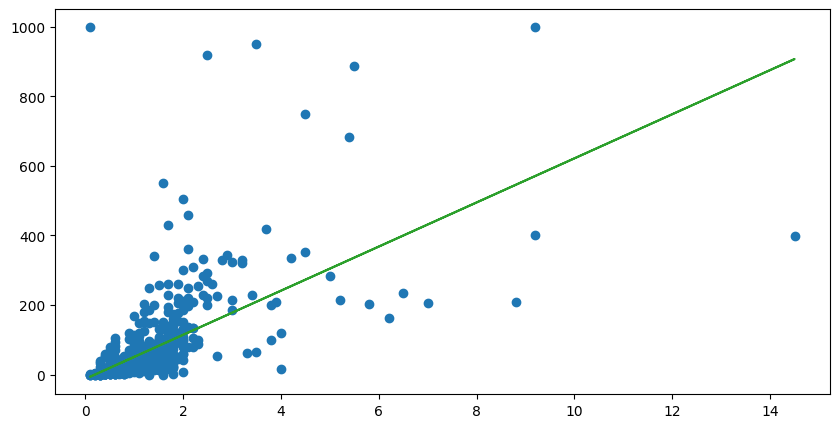

In [28]:
plt.figure(figsize=(10,5))
plt.plot(df['height'], df['weight'], 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = beta_hat[1], beta_hat[0]
#add linear regression line to scatterplot 
plt.plot(X, m*X+b);

## For educational purposes only

This is not recommended because the existing functions will perform this much quicker with greater accuracy and no errors BUT it is always nice to your hard won math skills at work.

In [29]:
def matrix_inverse(A):
    n = A.shape[0]  # Get the size of the matrix

    # Create an augmented matrix [A|I]
    AI = np.hstack((A, np.identity(n)))

    # Apply Gauss-Jordan elimination
    for i in range(n):
        # Normalize the i-th row
        AI[i] /= AI[i, i]

        # Make all elements above and below the i-th element in the i-th column to be zero
        for j in range(n):
            if j != i:
                AI[j] -= AI[j, i]*AI[i]

    # The inverse of A is now the right half of the augmented matrix
    return AI[:, n:]

In [30]:
# Test our function
XtX_inv = matrix_inverse(XtX)
print(XtX_inv)

# Check that XtX_inv is XtXinv
print(np.allclose(XtX_inv, XtXinv))

[[ 0.00276847 -0.00127852]
 [-0.00127852  0.00109849]]
True


## R Style OLS

It is a little nicer to just add variables to a function and obtain desired results.  The statsmodels library can do that for you.  In data theory or in grad school, the expectation is that you understand the underlying math.

In [31]:
# add constant to predictor variables to represent the intercept
# without it, you are forcing the line through the origin
height_1 = sm.add_constant(df['height'])
height_1[:4]

,const,height
0,1.0,0.7
1,1.0,1.0
2,1.0,2.0
3,1.0,0.6


In [32]:
# fit linear regression model
model = sm.OLS(df['weight'], height_1).fit()

In [33]:
summary = model.summary().as_html()
summary_html = '<div style="font-size: 10px">{}</div>'.format(summary)
display(HTML(summary_html))

In [34]:
#alternative fit linear regression model using a formula, adds the 1's for you
model_alt = smf.ols('weight ~ height', data = df).fit()
summary_alt = model_alt.summary().as_html()
summary_alt_html = '<div style="font-size: 10px">{}</div>'.format(summary_alt)
display(HTML(summary_alt_html))


## Produce the ANOVA table and predict results

They can both do this.

In [35]:
sm.stats.anova_lm(model_alt)

,df,sum_sq,mean_sq,F,PR(>F)
height,1.0,3.661703e+06,3.661703e+06,503.444563,2.143009e-86
Residual,779.0,5.665900e+06,7.273299e+03,NaN,NaN


In [36]:
model_alt.predict({'height' : 6})

0    368.093277
dtype: float64

## Diagnostic plots - in statsmodels

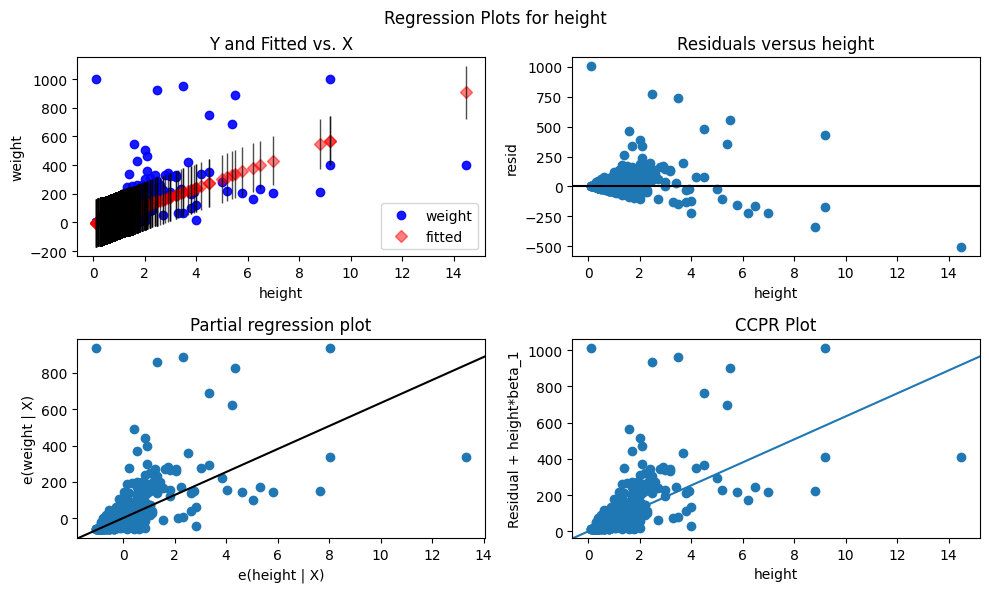

In [37]:
# define figure size
fig = plt.figure(figsize=(10,6))
# produce regression plots
fig = sm.graphics.plot_regress_exog(model_alt, 'height', fig=fig)

### sklearn.linear_model import LinearRegression

Scikit-learn is a machine learning library that includes functions for linear regression.  It doesn't have many options for linear regression.

In [38]:
# Create a numpy array of data:
height = np.array(df['height'])
weight = np.array(df['weight'])
x = height.reshape((-1, 1)) # -1 derives the correct length
y = weight

# Create an instance of a linear regression model and fit it to the data with the fit() function:
model = LinearRegression().fit(x, y) 

In [39]:
# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model.intercept_)

# Print the Slope:
print('slope:', model.coef_) 

coefficient of determination: 0.39256633577869215
intercept: -12.438175593660645
slope: [63.42190884]


In [40]:
# model rank - number of independent columns
print(f"Rank: {model.rank_}")

# Predict a Response and print it:
y_pred = model.predict(x)
print('Predicted response:', y_pred[0:10], sep='\n')

## of course we can work with the predicted values
np.mean(y_pred)

Rank: 1
Predicted response:
[ 31.9571606   50.98373325 114.40564209  25.61496971  57.32592413
  95.37906944  19.27277883  50.98373325  89.03687856   6.58839706]


61.37810499359796

## Logistic Regression Example - statsmodels

In [41]:
# relationship between age and congestive heart disease
chd = pd.read_csv("chdage.csv")

In [42]:
# the variable CHD is recorded as 0 or 1.
# pd.Categorical makes the data categorical rather than integer
chd.CHD = pd.Categorical(chd.CHD)

In [43]:
chd

,AGE,CHD
0,20,0
1,23,0
2,24,0
3,25,1
4,25,0
...,...,...
95,63,1
96,64,1
97,64,0
98,65,1


In [44]:
# change in data type is reflected here.
chd.dtypes

AGE       int64
CHD    category
dtype: object

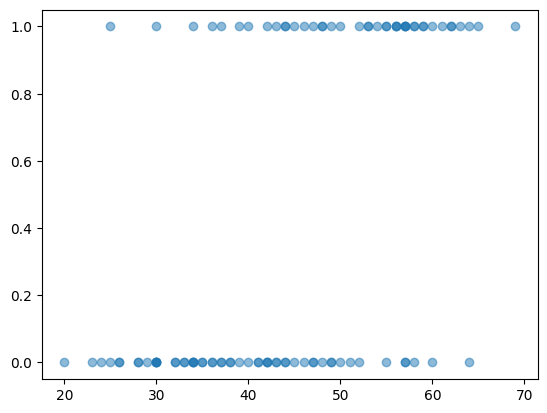

In [45]:
plt.scatter(chd.AGE, chd.CHD, alpha = 0.5);

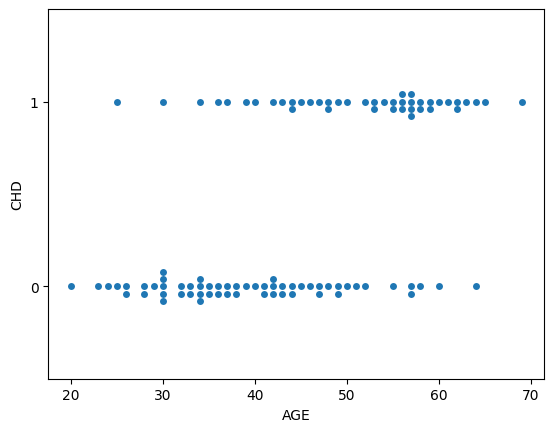

In [46]:
# seaborn swarm plot shows the density of values
sns.swarmplot(x = "AGE", y = "CHD", data = chd, orient = "horizontal", order = [1,0]);

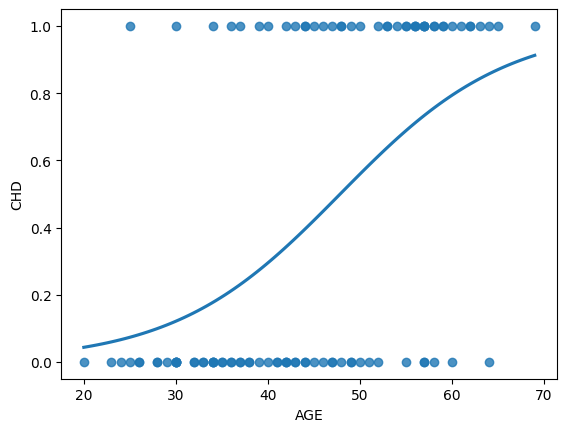

In [47]:
# shows potential logistic regression curve
sns.regplot(x="AGE", y="CHD", data=chd, logistic=True, ci=None);

$$y_i = 1 / \exp( - (\beta_0 + \beta_1 x_i + \epsilon_i) )$$

$$\mathbf{\hat{Y}} =1 / \exp( -\mathbf{X} \boldsymbol{\beta})$$


In [48]:
array_age = sm.add_constant(chd.AGE)
log_reg = sm.Logit(chd.CHD, array_age).fit()

Optimization terminated successfully.
         Current function value: 0.536765
         Iterations 6


In [49]:
summary_log_reg = log_reg.summary().as_html()
summary_log_reg_html = '<div style="font-size: 10px">{}</div>'.format(summary_log_reg)
display(HTML(summary_log_reg_html))


In [50]:
np.exp(log_reg.params)

const    0.004945
AGE      1.117307
dtype: float64

Interpretation - all other things being equal (controlling for other factors), for each one-year increase in age, we would expect about a 11.7% increase in the odds of CHD.

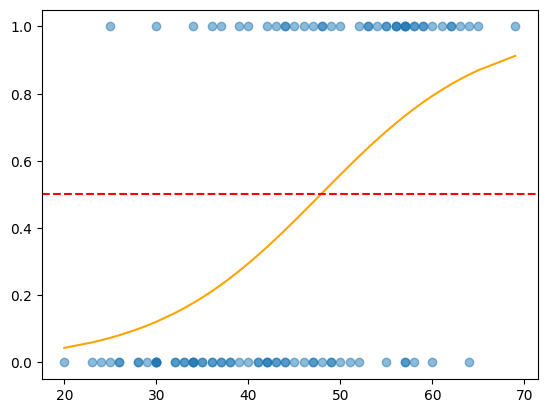

In [51]:
plt.scatter(chd.AGE, chd.CHD, alpha = 0.5)
plt.plot(chd.AGE, log_reg.predict(), color = 'orange')
plt.axhline(y = 0.5, color = 'red', linestyle = '--') # adding a horizontal line at y = 0.5
plt.show() # curve based on predictions

## scikit learn Logistic regression

Not very different but has more modern tools.

In [52]:
# Fit the classifier
clf = LogisticRegression(C=1e5, solver='liblinear') 
clf.fit(array_age, chd.CHD)

LogisticRegression(C=100000.0, solver='liblinear')

C is regularization strength. Higher regularization strength increases the penalty on the model's complexity. Low strength increases complexity and the chance of overfitting the data.

Solver is the optimization algorithm selection, this one is good for small datasets.

In [53]:
y_pred=clf.predict(array_age) 
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
cnf_matrix = metrics.confusion_matrix(chd.CHD, y_pred) 
cnf_matrix 

array([[45, 12],
       [14, 29]])

## Generating a confusion matrix plot

```
class_names=[0,1] # name  of classes 
plt.figure(figsize=(9,3))
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top") 
plt.tight_layout()
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label');
```

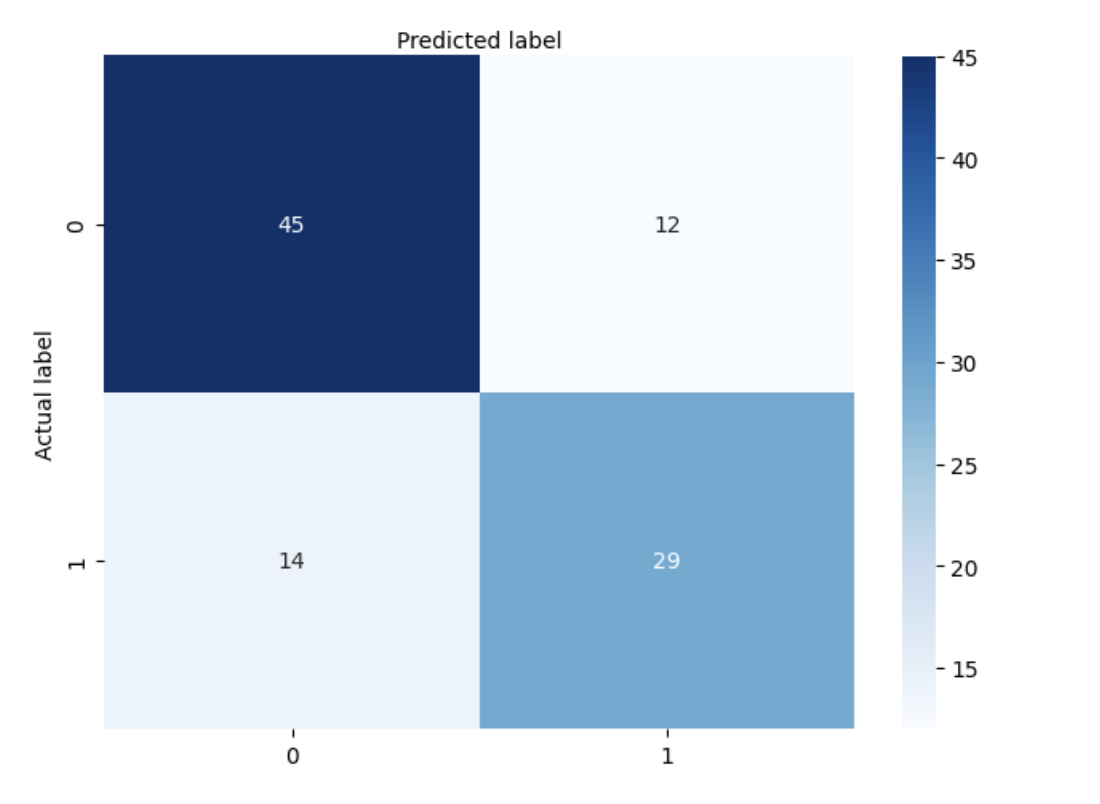

In [55]:
print("Accuracy:",metrics.accuracy_score(chd.CHD, y_pred))  
# proportion correctly predicted
print("Precision:",metrics.precision_score(chd.CHD, y_pred)) 
# the ratio true pos / (tp + fp) 
print("Recall:",metrics.recall_score(chd.CHD, y_pred)) 
# tp / (tp + fn) finding all pos.

Accuracy: 0.74
Precision: 0.7073170731707317
Recall: 0.6744186046511628


## How to sample/split your data

We split data into train and test to avoid overfitting.  In other words, rather than relying too much on the specific quirks of the one sample that we have -- we divide it as if we had more than one sample.

![img](https://algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png)



In Machine Learning, the primary way scientists select the best model is through the use of test sets and cross-validation.

The idea of a test set works as follows:

- Take all of the available data and split it into two parts - a training set and a test set.
- Using only the training portion, you will estimate the parameters of several competing models.


In [56]:
my_data = pd.read_csv("breast-cancer-wisconsin.data", header=None, index_col=0)
my_data

,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
776715,3,1,1,1,3,2,1,1,1,2
841769,2,1,1,1,2,1,1,1,1,2
888820,5,10,10,3,7,3,8,10,2,4


In [57]:
my_data = my_data.rename(columns={10: 'outcome'})
my_data

,1,2,3,4,5,6,7,8,9,outcome
0,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
776715,3,1,1,1,3,2,1,1,1,2
841769,2,1,1,1,2,1,1,1,1,2
888820,5,10,10,3,7,3,8,10,2,4


In [58]:
RS = 3
my_sample_1 = my_data.sample(frac = 0.48, random_state= RS)
my_sample_1

,1,2,3,4,5,6,7,8,9,outcome
0,,,,,,,,,,
1080233,7,6,6,3,2,10,7,1,1,4
76389,10,4,7,2,2,8,6,1,1,4
1275807,4,2,4,3,2,2,2,1,1,2
1311108,1,1,1,3,2,1,1,1,1,2
1181685,1,1,2,1,2,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...
704168,4,6,5,6,7,?,4,9,1,2
263538,5,10,10,6,10,10,10,6,5,4
1183240,4,1,2,1,2,1,2,1,1,2


In [59]:
my_sample_2 = my_data.drop(my_sample_1.index)
my_sample_2

,1,2,3,4,5,6,7,8,9,outcome
0,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
714039,3,1,1,1,2,1,1,1,1,2
763235,3,1,1,1,2,1,2,1,2,2
776715,3,1,1,1,3,2,1,1,1,2


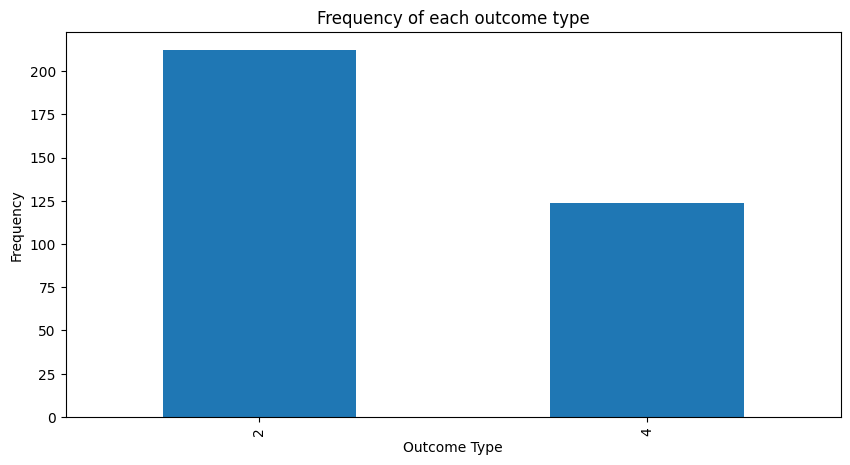

In [60]:
# plot of the outcome variable 
ax = my_sample_1['outcome'].value_counts().\
    plot(kind='bar',figsize=(10,5),title="Frequency of each outcome type")
ax.set_xlabel("Outcome Type")
ax.set_ylabel("Frequency");

In [61]:
print("Percent Distribution")
print(my_sample_1['outcome'].value_counts(normalize= True)*100)

Percent Distribution
outcome
2    63.095238
4    36.904762
Name: proportion, dtype: float64


In [62]:
# Check Missing Data
total = my_data.isnull().sum().sort_values(ascending=False)
percent = (my_data.isnull().sum()/my_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent * 100], axis=1, keys=['Total', 'Percent(%)'])
missing_data

,Total,Percent(%)
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0
outcome,0,0.0


In [63]:
my_data.describe()

,1,2,3,4,5,7,8,9,outcome
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


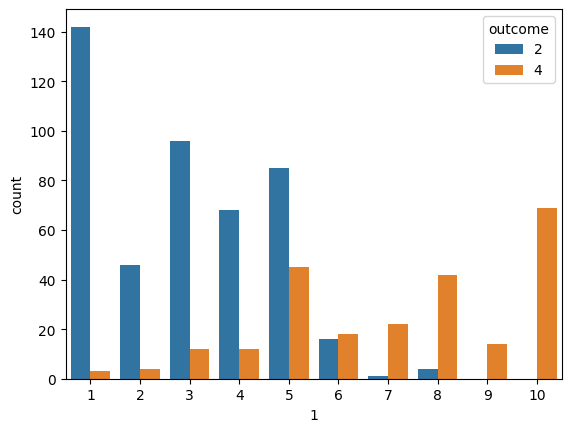

In [64]:
sns.countplot(x=1, hue='outcome', data= my_data);

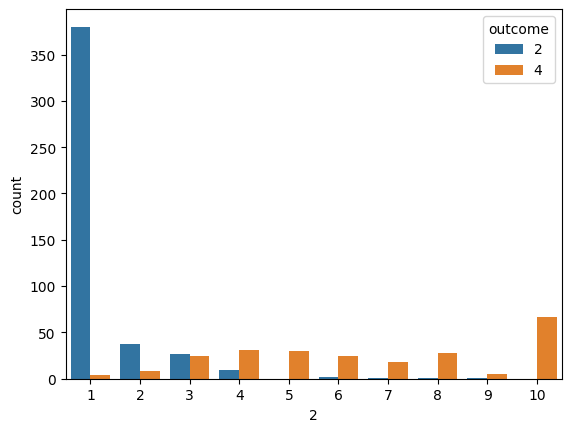

In [65]:
sns.countplot(x=2, hue='outcome', data= my_data);

In [66]:
my_data.groupby([2, 'outcome']).size()

2   outcome
1   2          380
    4            4
2   2           37
    4            8
3   2           27
    4           25
4   2            9
    4           31
5   4           30
6   2            2
    4           25
7   2            1
    4           18
8   2            1
    4           28
9   2            1
    4            5
10  4           67
dtype: int64

In [67]:
cross_table = pd.crosstab(my_sample_1[2], my_sample_1['outcome'])
print(cross_table)

outcome    2   4
2               
1        171   2
2         21   5
3         13  12
4          5  21
5          0  13
6          2  13
7          0   9
8          0  14
9          0   4
10         0  31


In [68]:
features = [1, 2]
X = my_sample_1[features]
y = my_sample_1['outcome']

In [69]:
# Fit the classifier
clf = LogisticRegression(C=1e5, solver='liblinear') 
clf.fit(X, y)

y_pred=clf.predict(X) 
y_pred

array([4, 4, 2, 2, 2, 4, 2, 4, 2, 4, 4, 2, 4, 2, 2, 4, 4, 4, 2, 2, 2, 2,
       4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4,
       4, 2, 4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2,
       2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4,
       2, 4, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 4, 4, 2, 2, 4, 4, 4,
       2, 2, 4, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2,
       4, 2, 4, 4, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2,
       4, 4, 2, 2, 2, 4, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 4, 2, 4,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4, 2,
       2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4,
       4, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 2, 4, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 2,
       4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 4,

In [70]:
cnf_matrix = metrics.confusion_matrix(my_sample_1['outcome'], y_pred) 
cnf_matrix 

array([[205,   7],
       [ 13, 111]])

## Confusion Matrix Plot

```
class_names=[2,4] # name  of classes 
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label');
```

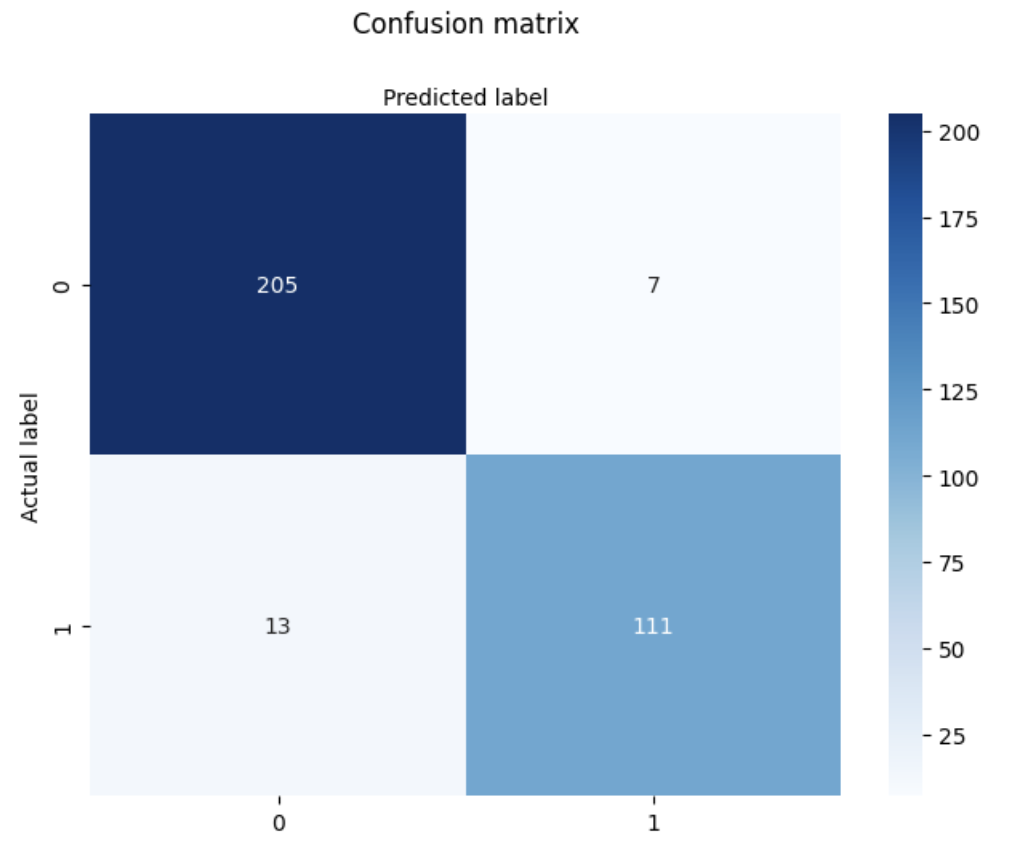

In [71]:
print("Accuracy:",metrics.accuracy_score(my_sample_1['outcome'], y_pred))  # correctly predicted
print("Precision:",metrics.precision_score(my_sample_1['outcome'], y_pred, pos_label=4)) #  ratio tp / (tp + fp)
print("Recall:",metrics.recall_score(my_sample_1['outcome'], y_pred, pos_label=4)) # tp / (tp + fn) finding all pos.

Accuracy: 0.9404761904761905
Precision: 0.940677966101695
Recall: 0.8951612903225806


## Generate predictions for the other sample

So we had set aside some of the data.  So now, we can apply it to the estimated model and generate predictions - and we want to see how stable our estimates are:

In [72]:
X_2 = my_sample_2[features]
y_pred_2=clf.predict(X_2) 
y_pred_2

cnf_matrix2 = metrics.confusion_matrix(my_sample_2['outcome'], y_pred_2) 

print(cnf_matrix2)

print("Accuracy:",metrics.accuracy_score(my_sample_2['outcome'], y_pred_2))  # correctly predicted
print("Precision:",metrics.precision_score(my_sample_2['outcome'], y_pred_2, pos_label=4)) #  ratio tp / (tp + fp)
print("Recall:",metrics.recall_score(my_sample_2['outcome'], y_pred_2, pos_label=4)) # tp / (tp + fn) finding all pos.


[[216   9]
 [ 10 101]]
Accuracy: 0.9434523809523809
Precision: 0.9181818181818182
Recall: 0.9099099099099099


<h1> Statistics 21 <br/> Have a good night! </h1>

<script>
    setBackgroundImage('Window1.jpg', 'black');
</script>